In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')


In [68]:
def density(x,y):
    return np.exp(-50*x*x-15*y*y-50*x*y)
    

In [83]:

# initial point 
x0, y0 = np.array([-3,3])

Listx , Listy = [x0], [y0]

# number of sample 
N = 1000


for i in range(N):
    xn, yn = random.uniform(-1,1),random.uniform(-1,1)
    a = density(xn,yn)/density(x0,y0) 
    if a >=1:
        Listx = Listx +[xn]
        Listy = Listy +[yn]
        x0,y0 = xn, yn 
    else:
        if random.random()<a:
            Listx = Listx + [xn]
            Listy = Listy +[yn]
            x0,y0 = xn, yn
            


In [84]:
len(Listx)

128

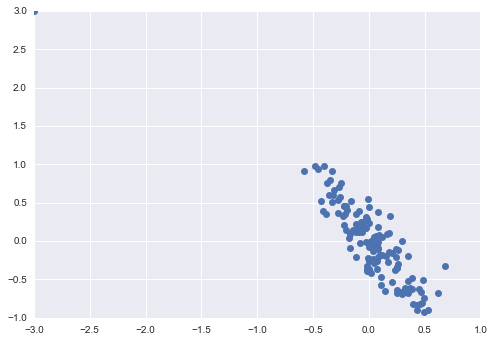

In [85]:
plt.plot(Listx, Listy,'o')

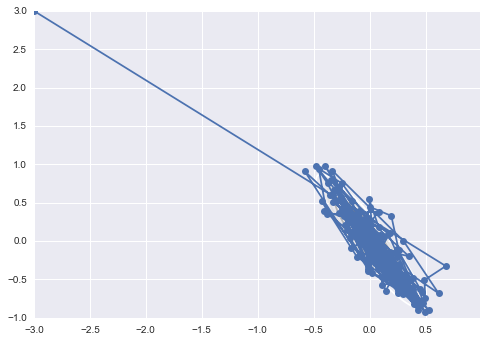

In [86]:
plt.figure()
plt.plot(Listx, Listy,'o-')
x = np.arange(-1, 1, 0.01)
y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(x, y)
plt.contour(X,Y,density(X,Y))

In [87]:
def density2(x1,x2,p1,p2):
    return np.exp(-50*x1*x1-50*x2*x2-15*x1*x2-p1*p1/2.0-p2*p2/2.0)

def gradE(x):
    return np.array([100*x[0]+15*x[1],15*x[0]+100*x[1]])



# initial point 
x0 = np.array([-0.5,0.5])

Listx = [x0]

# number of samples 
N = 100
T = 100
epsilon = 0.1


for i in range(N): 
    p0 = np.random.normal(0,1,2)

    for t in range(T):
        ph = p0 - epsilon* gradE(x0)/2.0
        xn = x0 + epsilon* ph
        pn = ph - epsilon* gradE(xn)/2
    

    a = density2(xn[0],xn[1],pn[0],pn[1])/density2(x0[0],x0[1],p0[0],p0[1])

    if a >=1:
        Listx = Listx +[xn]
        x0,p0 = xn, pn 
    else:
        if random.random() < a:
            Listx = Listx + [xn]
            x0,p0 = xn, pn
            



In [88]:
len(Listx)

91

In [89]:
x11=[Listx[i][0] for i in range(len(Listx))]
x22=[Listx[i][1] for i in range(len(Listx))]

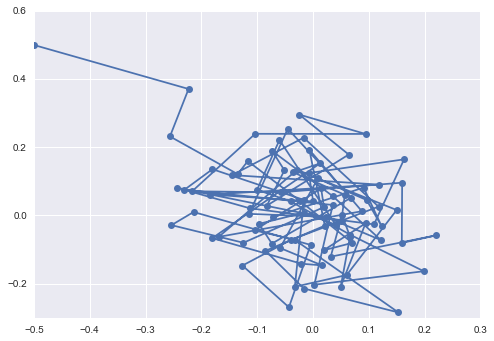

In [90]:
plt.plot(x11,x22,'o-')

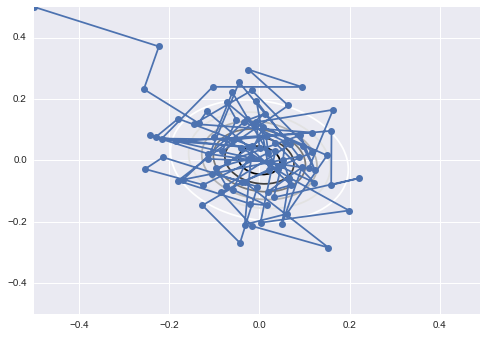

In [91]:
plt.figure()
plt.plot(x11,x22,'o-')
x1 = np.arange(-0.5, 0.5, 0.01)
x2 = np.arange(-0.5, 0.5, 0.01)
X1, X2 = np.meshgrid(x1, x2)
plt.contour(X1,X2,np.exp(-50*X1*X1-50*X2*X2-15*X1*X2))

In [92]:
import scipy.linalg as la
import seaborn as sns

In [93]:
def E(tau, u0, v0, u, v):
    """energy gap"""
    return (np.dot(np.dot(u0 , tau) , u0) + np.dot(v0 , v0)) - (np.dot(np.dot(u , tau) , u) + np.dot(v , v))

def leapfrog(A, u, v, h, N):
    """Leapfrog finite difference scheme."""
    v = v - h/2 * np.dot(A , u)
    for i in range(N-1):
        u = u + h * v
        v = v - h * np.dot(A , u)

    u = u + h * v
    v = v - h/2 * np.dot(A , u)

    return u, v

In [94]:
def E(tau, u0, v0, u, v):
    """energy gap"""
    return (np.dot(np.dot(u0 , tau) , u0) + np.dot(v0 , v0))/2 - (np.dot(np.dot(u , tau) , u) + np.dot(v , v))/2

def leapfrog(A, u, v, h, N):
    """Leapfrog finite difference scheme."""
    v = v - h * np.dot(A , u)
    for i in range(N-1):
        u = u + h * v
        v = v - h * np.dot(A , u)

    u = u + h * v
    v = v - h * np.dot(A , u)

    return u, v

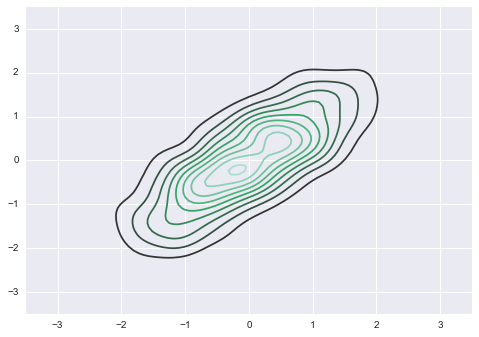

In [4]:
sigma = np.array([[1,0.8],[0.8,1]])
mu = np.zeros(2)
ys = np.random.multivariate_normal(mu, sigma, 1000)
sns.kdeplot(ys)
plt.axis([-3.5,3.5,-3.5,3.5])
pass

In [96]:
niter = 100
h = 0.01
N = 400

tau =  np.array([[1/5.0,1/6.0],[1/6.0,1/4.0]])



orbit = np.zeros((niter+1, 2))
u = np.array([-3,3])
orbit[0] = u
for k in range(niter):
    v0 = np.random.normal(0,1,2)
    u, v = leapfrog(tau, u, v0, h, N)

    # accept-reject
    u0 = orbit[k]
    a = np.exp(E(tau, u0, v0, u, v))
    r = np.random.rand()

    if r < a:
        orbit[k+1] = u
    else:
        orbit[k+1] = u0

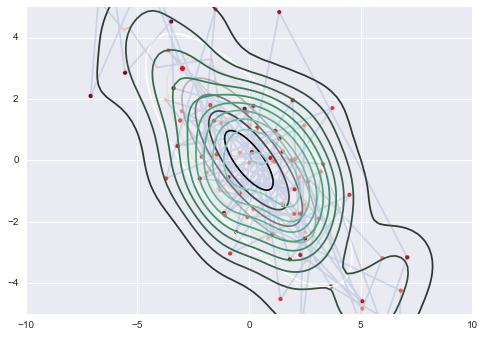

In [97]:
plt.figure()
x1 = np.arange(-10, 10, 0.1)
x2 = np.arange(-5, 5, 0.1)
X1, X2 = np.meshgrid(x1, x2)
plt.contour(X1,X2,np.exp(-X1*X1/5.0-X2*X2/4.0-X1*X2/3.0))

sns.kdeplot(orbit)
plt.plot(orbit[:,0], orbit[:,1], alpha=0.2)
plt.scatter(orbit[:1,0], orbit[:1,1],  c='red', s=30)
plt.scatter(orbit[1:,0], orbit[1:,1],  c=np.arange(niter)[::-1], cmap='Reds')
plt.axis([-10,10,-5,5])
pass

[-10, 10, -5, 5]

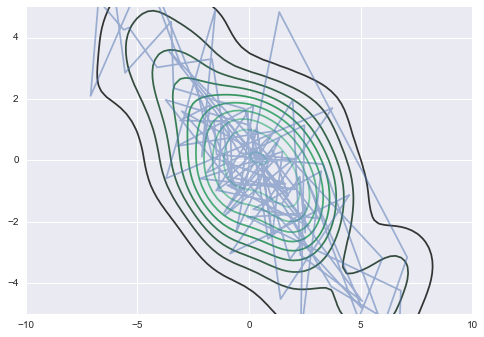

In [100]:
sns.kdeplot(orbit)
plt.plot(orbit[:,0], orbit[:,1], alpha=0.5)
plt.axis([-10,10,-5,5])

